In [109]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [110]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [111]:
from sklearn.svm import SVC

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
import sys
sys.path.append('./')

In [114]:
from keras import backend as K

def mee_keras(y_true, y_pred):
  return K.mean(K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True)))

# Data Preparation

In [115]:
# Read and view TR
# dataset = "cup/ML-CUP20-TR.csv"
dataset="/content/drive/My Drive/Machine Learning Project/CUP/data/ML-CUP20-TR.csv"

# Column 0:     ID
# Column 1-10:  inputs
# Column 11-12: target_x target_y
train_names = ["id", "input_1", "input_2", "input_3", "input_4", "input_5", "input_6", "input_7", "input_8", "input_9",
               "input_10", "target_x", "target_y"]
df_train = pd.DataFrame(pd.read_csv(dataset, sep=',', skiprows=7, header=None, names=train_names, index_col=0))

# Store the number of training patterns
n_TR_patterns = len(df_train.index)
print(f'N. rows TR: {n_TR_patterns}\n')

# log.write(f'N. rows TR: {n_TR_patterns}\n')

# print(df_train.head())

# Read and view TS
# dataset = "cup/ML-CUP20-TS.csv"
dataset="/content/drive/My Drive/Machine Learning Project/CUP/data/ML-CUP20-TS.csv"

# Column 0:    ID
# Column 1-10: inputs
test_names = ["id", "input_1", "input_2", "input_3", "input_4", "input_5", "input_6", "input_7", "input_8", "input_9",
              "input_10"]
df_test = pd.DataFrame(pd.read_csv(dataset, sep=',', skiprows=7, header=None, names=test_names, index_col=0))

# Store the number of (blind) testing patterns
n_TS_patterns = len(df_test.index)
print(f'N. rows TS: {n_TS_patterns}\n')

N. rows TR: 1524

N. rows TS: 472



In [116]:
# Previously
df_train.head(), df_test.head()

(     input_1   input_2   input_3  ...  input_10   target_x   target_y
 id                                ...                                
 1  -1.227729  0.740105  0.453528  ... -1.399807  58.616635 -36.878797
 2  -1.138424  0.401816  2.186819  ... -0.886397  75.310457 -27.210492
 3  -0.932510  1.226327  1.086944  ... -1.385428  68.513133 -31.582073
 4  -1.037358  1.370826  0.945194  ... -0.583328  57.655634 -37.409493
 5   0.484440  0.192628 -0.348715  ...  1.439752  43.327791 -35.763594
 
 [5 rows x 12 columns],
      input_1   input_2   input_3  ...   input_8   input_9  input_10
 id                                ...                              
 1   0.807179 -0.490503 -0.316058  ... -0.869237 -0.362536  1.361925
 2  -1.223277  1.115751  0.942666  ...  0.680087  1.326409 -1.462774
 3  -1.342716  0.639824  1.400384  ... -0.869237  0.819726 -1.049404
 4   1.284933 -1.561339 -1.174280  ... -0.869237 -1.207009  0.672974
 5  -1.402435  1.353715  0.942666  ...  0.820935  1.270111 -0.9

In [117]:
# Divide into TR, VL, and (internal) TS
attributes = [col for col in df_train.columns if 'input' in col]

# Separating internal TS from the rest of training dataset (Hold out ca. 20%)
print("\ndf_train ", len(df_train))  # 1524

df_subset = df_train.sample(304, random_state=100)
print("\ndf_subset ", len(df_subset))  # 304
print(df_subset.head())

df_train = df_train.drop(df_subset.index)
print("\ndf_train after removal ", len(df_train))  # 1220

X_train = df_train[attributes].values
y_train = df_train[['target_x', 'target_y']].values


n_features = X_train.shape[1]
print(X_train.shape[0])

print(f'\nN. input features: {n_features}')

# log.write(f'\nN. input features: {n_features}')

# Handle (blind) TS
attributes = [col for col in df_test.columns if 'input' in col]
X_blind_TS = df_test[attributes].values


df_train  1524

df_subset  304
       input_1   input_2   input_3  ...  input_10   target_x   target_y
id                                  ...                                
801   1.155300  0.059795 -0.604900  ...  1.727382  39.929663 -29.595517
720  -0.918605  0.637450  1.347002  ... -0.903759  72.384610 -28.855841
1059 -0.652593  1.394323  0.103282  ... -1.030427  52.796461 -39.445597
189   1.439956 -0.605409 -0.758339  ...  1.819379  40.553341 -30.551312
229   0.915644 -1.250489 -1.028318  ...  0.055362  31.467524 -13.706777

[5 rows x 12 columns]

df_train after removal  1220
1220

N. input features: 10


In [118]:
X_test = df_subset[attributes].values
y_test = df_subset[['target_x', 'target_y']].values

#SVR

In [119]:
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

#GRID SEARCH

In [120]:
svr = SVR(C=1.0, epsilon=0.2)
mor = MultiOutputRegressor(svr)

In [126]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid={
              'estimator__kernel': ['rbf', 'poly'],
              'estimator__C': [6, 7, 8],
              'estimator__epsilon': [0.9, 1, 1.1],
              'estimator__gamma': [0.09, 0.08, 0.07]
           }
# Create a based model
svr = SVR(kernel='kernel', C='C', epsilon='epsilon', gamma='gamma')
mor = MultiOutputRegressor(svr)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = mor, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [127]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_

best_grid

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   12.6s finished


MultiOutputRegressor(estimator=SVR(C=8, cache_size=200, coef0=0.0, degree=3,
                                   epsilon=1, gamma=0.07, kernel='rbf',
                                   max_iter=-1, shrinking=True, tol=0.001,
                                   verbose=False),
                     n_jobs=None)

In [128]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_grid, X_train, y_train, cv=3)

print("Mean R2 with cross-validation: ", scores.mean())

Mean R2 with cross-validation:  0.9391048363701929


R2 on test set:  0.9467177034749426
MSE on test set:  7.422312039187085
MEE on test set:  3.087414486429163


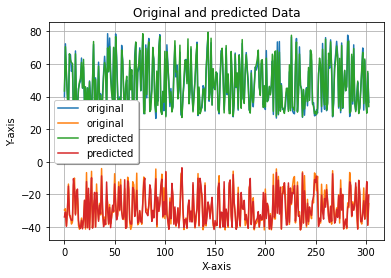

In [129]:
ypred = best_grid.predict(X_test)

score = best_grid.score(X_test, y_test)
print("R2 on test set: ", score)

mse = mean_squared_error(y_test, ypred)
mee = mee_keras(y_test, ypred)
print("MSE on test set: ", mse)
print("MEE on test set: ", float(mee))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Original and predicted Data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()   